## Image scaling using Bicubic Interpoltion

### The whole algorithm was divided into 4 steps

### Step 1: Mapping Output Coordinates to Input Coordinates and Identifying Neighboring Pixels

#### **Sub-Step 1.1: Finding Corresponding Coordinates in the Input Image**
- **What We Do:** For each pixel in the resized (output) image, calculate where it corresponds in the original (input) image.
- **Why We Do It:** Since the output and input images have different sizes, we need to find the exact location in the input image that matches each pixel in the output image.
- **How We Do It:** Use the formulas `src_x = (x / output_width) * input_width` and `src_y = (y / output_height) * input_height`.
- **Example:** If the output image is 900x900 pixels and the input image is 450x450 pixels, for a pixel at (450, 450) in the output image, the corresponding coordinates in the input image would be (225, 225).

#### **Sub-Step 1.2: Identifying the 16 Neighboring Pixels**
- **What We Do:** Identify the 16 pixels around the calculated point in the input image that will influence the color of the pixel in the output image.
- **Why We Do It:** Bicubic interpolation uses the values of these 16 pixels to calculate the new pixel value, ensuring a smoother transition and better image quality.
- **How We Do It:** Find the top-left corner of the 4x4 grid of neighboring pixels using `top_left_x = floor(src_x) - 1` and `top_left_y = floor(src_y) - 1`, then identify all 16 pixels in the grid.
- **Example:** If `src_x = 225.6` and `src_y = 225.3`, the top-left corner of the grid would be at (224, 224), and the 16 pixels would be those surrounding this point in a 4x4 grid.

### Step 2: Calculating Distances and Determining Weights

#### **Sub-Step 2.1: Calculating the Fractional Part of the Coordinates**
- **What We Do:** Calculate the exact sub-pixel position within the top-left pixel of the 4x4 grid.
- **Why We Do It:** This fractional part tells us how far the exact location is from the boundaries of the top-left pixel, which is crucial for determining the influence of neighboring pixels.
- **How We Do It:** Use `frac_x = src_x - floor(src_x)` and `frac_y = src_y - floor(src_y)`.
- **Example:** For `src_x = 225.6` and `src_y = 225.3`, the fractional parts would be `0.6` and `0.3`, respectively.

#### **Sub-Step 2.2: Calculating Distances to Each Neighboring Pixel**
- **What We Do:** Measure how far the fractional part is from each of the 16 neighboring pixels.
- **Why We Do It:** These distances help determine how much each neighboring pixel influences the color of the new pixel. Closer pixels have more influence.
- **How We Do It:** Calculate the horizontal and vertical distances for each neighboring pixel using the fractional parts.
- **Example:** For the top-left pixel at (224, 224), the distances would be `abs(224 - (224 + 0.6))` and `abs(224 - (224 + 0.3))`, resulting in distances of `0.6` and `0.3`.

#### **Sub-Step 2.3: Determining Weights Using Cubic Convolution**
- **What We Do:** Apply a cubic convolution kernel to the distances to determine the weights for interpolation.
- **Why We Do It:** The weights calculated from these distances are used to compute a weighted sum of the pixel values from the original image, which forms the interpolated value.
- **How We Do It:** Use the cubic convolution formula based on the distances calculated.
- **Example:** If the distance is `0.6`, the weight calculated using the cubic convolution formula would be based on this distance value.



### Step 3: Applying the Cubic Convolution Kernel

**Objective**: Calculate weights for interpolation using the cubic convolution kernel function based on the distances from Step 2.

#### Sub-steps and Details:

1. **Define the Cubic Convolution Kernel Function**:
   - **Function**: \( f(x) \), defined piecewise for different ranges of \( x \) (the distance).
   - **Formula**:
     $$
     f(x) =
     \begin{cases}
     (a + 2)|x|^3 - (a + 3)|x|^2 + 1 & \text{for } |x| < 1, \\
     a|x|^3 - 5a|x|^2 + 8a|x| - 4a & \text{for } 1 \leq |x| < 2, \\
     0 & \text{otherwise},
     \end{cases}
     $$
   - **Parameter \( a \)**: Controls sharpness. Commonly set to -0.5. Lower values yield sharper images.
   - **Why**: This function determines how much each neighboring pixel influences the new pixel, based on distance.

2. **Calculate Weights for Each Neighboring Pixel**:
   - **Process**: Apply the kernel function to both horizontal and vertical distances for each neighboring pixel.
   - **Weight Calculation**: Multiply the results of the kernel function for horizontal and vertical distances.
   - **Why**: These weights are crucial for blending pixel values accurately in the next step.

#### Example for Step 3:
Suppose we have a distance of 0.6 horizontally and 1.2 vertically for a neighboring pixel. The weights are calculated as follows:
- Horizontal weight: \( f(0.6) \) using the first case of the function.
- Vertical weight: \( f(1.2) \) using the second case.
- Total weight: Product of horizontal and vertical weights.

### Step 4: Computing the Interpolated Value

**Objective**: Use the weights from Step 3 to compute the interpolated value for the new pixel.

#### Sub-steps and Details:

1. **Retrieve Pixel Values**:
   - **Process**: Get the pixel values (grayscale or RGB) for each of the 16 neighboring pixels.
   - **Why**: These are the values that will be blended to create the new pixel.

2. **Compute the Weighted Sum**:
   - **Calculation**: Multiply each pixel value by its corresponding weight and sum these products.
   - **Formula**:
     $$
     \text{Interpolated Value} = \sum_{i=1}^{16} (\text{Pixel Value}_i \times \text{Weight}_i)
     $$
   - **Why**: This step blends the pixel values, considering their proximity and influence, to determine the color or intensity of the new pixel.

3. **Normalization**:
   - **Process**: Ensure the interpolated value is within the valid range (e.g., 0-255 for 8-bit images).
   - **Why**: To maintain the integrity of pixel values and avoid overflow or underflow.

#### Example for Step 4:
Imagine we have the pixel values and their corresponding weights from the previous steps. For a new pixel, we calculate the interpolated value by multiplying each of the 16 neighboring pixel values by their weights and summing these products. If the result is, say, 260, we clamp it to 255 for an 8-bit image.

### Overall Understanding:
In bicubic interpolation, Steps 3 and 4 are about calculating the influence of neighboring pixels (Step 3) and then using these influences to blend their values to create a new pixel in the resized image (Step 4). This process ensures a smooth transition between pixels, resulting in a high-quality resized image with minimal artifacts.

In [45]:
from PIL import Image
import numpy as np
import math

This function applies the cubic convolution algorithm to a given distance value and a specific parameter a.
The function uses different cubic equations based on the absolute value of the distance.
The parameter a is typically set to -0.5, but it can be adjusted for different smoothing effects.

In [46]:
def cubicConv(x, a):
    if abs(x) < 1:
        return (a + 2) * abs(x)**3 - (a + 3) * abs(x)**2 + 1
    elif abs(x) < 2:
        return a * abs(x)**3 - 5 * a * abs(x)**2 + 8 * a * abs(x) - 4 * a
    else:
        return 0

This function retrieves the pixel value from the image at specified coordinates (x, y).
It includes boundary checks to ensure that the coordinates do not fall outside the image dimensions. If they do, it returns a default value (like 0 for black).

In [47]:
def getPixel(image, x, y):
    if x < 0 or y < 0 or x >= len(image[0]) or y >= len(image):
        return 0
    return image[y][x]

Image loading

In [48]:
imagePath = '/content/policeman-1.jpg'
image = Image.open(imagePath)
grayImage = image.convert('L')
grayArray = np.array(grayImage)

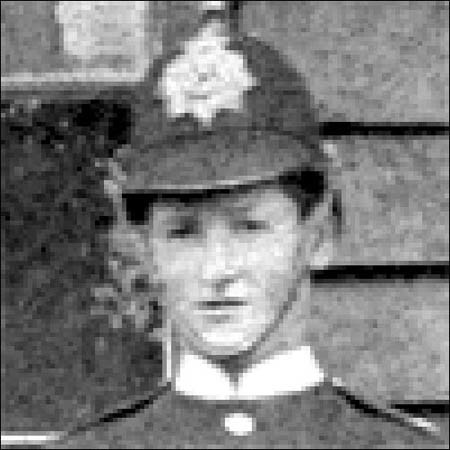

In [49]:
grayImage

Defining the dimensions of the input and output images and initialize an array for the output image.

In [50]:
inputHeight, inputWidth = grayArray.shape
outputWidth, outputHeight = 900, 900

Parameter ( a ): Controls sharpness. Commonly set to -0.5. Lower values yield sharper images. Given as a parameter to the conv  kernel function.

In [51]:
result = np.zeros((outputHeight, outputWidth))

a = -0.5

In [52]:
#Step 1 of Bicubic Interpolation: Identify Neighboring Pixels
#This section maps each pixel in the output image to its corresponding location in the original image and identifies the 16 neighboring pixels around this location.

for y in range(outputHeight):
    for x in range(outputWidth):
        srcX = (x / outputWidth) * inputWidth
        srcY = (y / outputHeight) * inputHeight

        topLeftX = math.floor(srcX) - 1
        topLeftY = math.floor(srcY) - 1

        neighbors = []
        for i in range(4):
            for j in range(4):
                neiX = topLeftX + i
                neiY = topLeftY + j
                neighbors.append((neiX, neiY))

#Step 2 of Bicubic Interpolation: Calculate Distances
#Thsi section calculates the fractional part of the source coordinates and the distances from the sub-pixel position to each of the 16 neighboring pixels.
        fracX = srcX - math.floor(srcX)
        fracY = srcY - math.floor(srcY)

        distances = []
        for neighbor in neighbors:
            distX = abs(neighbor[0] - (topLeftX + fracX))
            distY = abs(neighbor[1] - (topLeftY + fracY))
            distances.append((distX, distY))

#Step 3 of Bicubic Interpolation: Determine Weights Using Cubic Convolution
#THis section applies the cubic convolution function to each distance to calculate the weights for interpolation.

        weights = []
        for distance in distances:
            weightX = cubicConv(distance[0], a)
            weightY = cubicConv(distance[1], a)
            weight = weightX * weightY
            weights.append(weight)

#Step 4 of Bicubic Interpolation: Compute the Interpolated Value
#This section computes the interpolated value for each pixel in the output image using the weights and pixel values from the original image.

        interpolated = 0
        for i in range(len(neighbors)):
            pixel = getPixel(grayArray, neighbors[i][0], neighbors[i][1])
            weight = weights[i]
            interpolated += pixel * weight

        interpolated = max(0, min(interpolated, 255))
        result[y, x] = interpolated

In [53]:
resultImage = Image.fromarray(result.astype('uint8'), 'L')

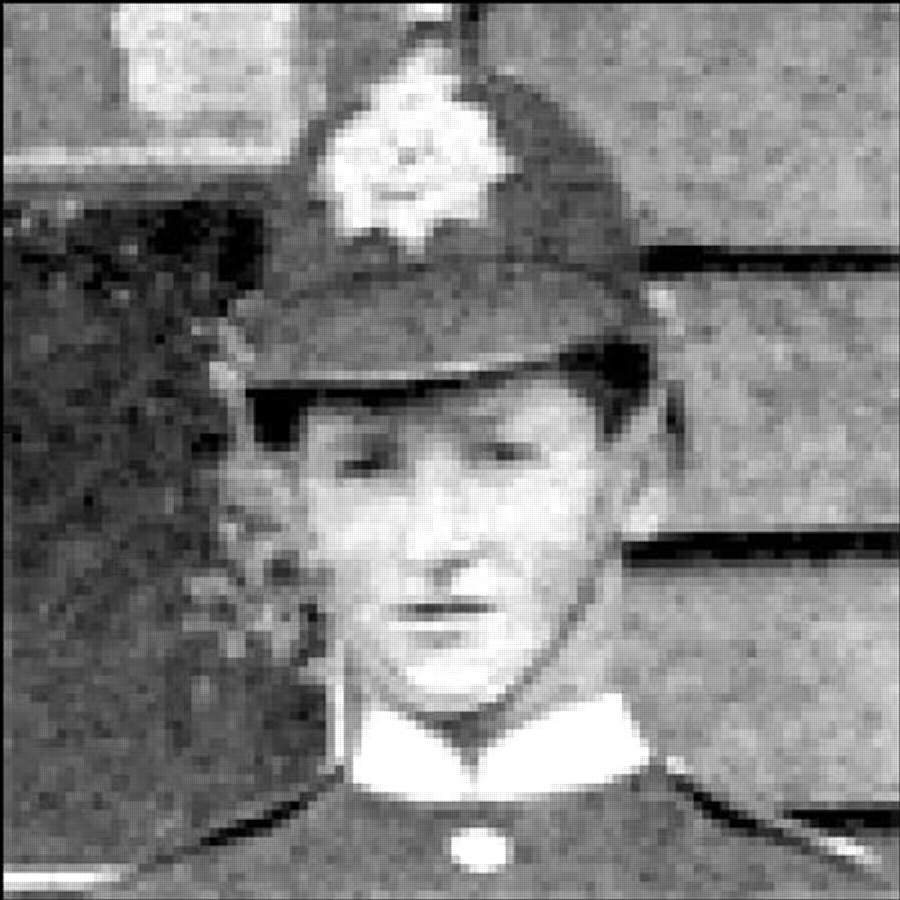

In [54]:
resultImage

In [36]:
!pip install opencv-python


Gaussian Blur for Noise Reduction

In [55]:
import cv2

resultArray = np.array(resultImage)

barray = cv2.GaussianBlur(resultArray, (15, 15), 0)

UpdatedImage = Image.fromarray(barray)

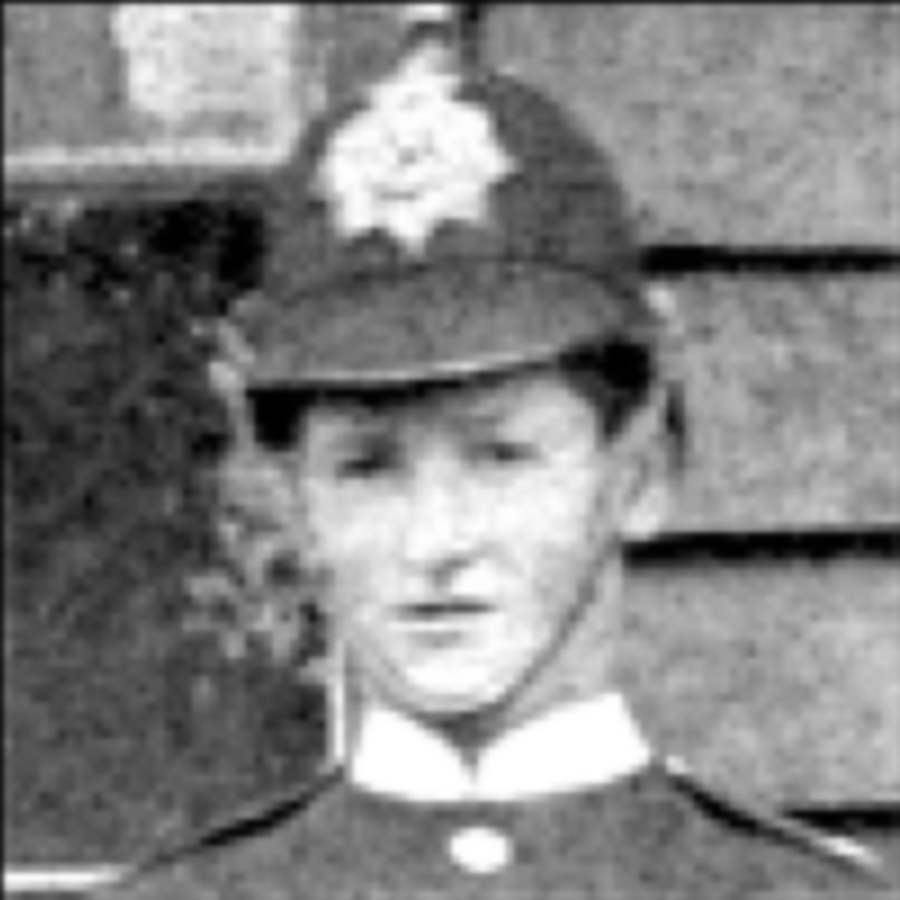

In [56]:
UpdatedImage